# tf.data 모듈
- 데이터 입력 파이프라인을 위한 모듈
    - 모델 학습 / 평가를 위한 데이터셋을 제공(feeding)하기 위한 모듈
    - raw dataset에서 입력을 위한 **전처리, 배치 크기, shuffling** 등을 한번에 처리할 수 있게 한다
- tf.data.Dataset 추상 클래스에서 상속된 여러가지 클래스들을 제공
    - 입력 소스의 제공 형태, 어떤 처리를 하는지에 따라 다양한 하위 클래스들이 제공

## Dataset API 사용
1. **Dataset 생성**
    - raw dataset을 지정 (Loading)
    - from_tensor_slices(), from_generator() 클래스 메소드, tf.dataTFRecordDataset 클래스등을 사용해 메모리나 파일에 있는 데이터를 Dataset으로 만든다
    - **from_tensor_slices()**: 메모리의 리스트, 넘파이 배열, 텐서플로 자료형에서 데이터를 생성
2. **제공 데이터 전처리**
    - **map(함수)**: Dataset이 제공하는 원소를 처리해 변환된 원소를 제공
        - 함수: 원소를 어떻게 변환할 지 정의한 함수를 매개변수로 전달
            - 매개변수: Dataset이 제공하는 원소를 받을 변수
            - 반환값: Dataset이 제공한 원소를 변경처리한 값
    - **filter(함수)**: Dataset이 제공하는 원소중 특정 조건을 만족하는(True)인 원소들만 제공
        - 함수: 원소가 특정조건을 만족하는지 여부를 확인하는 로직을 정의한 함수를 매개변수로 전달
            - 매개변수: Dataset이 제공하는 원소를 받을 변수
            - 반환값: Dataset이 제공한 원소가 특정조건을 만족하는지 여부(bool)
3. **데이터 제공 설정 관련**
    - **batch(size)**: 학습/평가 시 한번에 제공할 batch size 지정
        - size: int, batch size 지정
        - drop_remainder: bool, True일 경우 마지막 제공 시 남은 데이터수가 batch size보다 작으면 제공하지 않는다
    - **shuffle(buffer 크기)**: dataset의 원소들의 순서를 섞는다
        - buffer 크기: int, buffer 크기는 섞는 공간의 크기로 **데이터보다 크거나 같으면 `완전셔플`**, **적으면 일부만 가져와서 섞어** 완전셔플이 안된다
        - 데이터 사이즈가 너무 커서 메모리가 부족할 경우 버퍼크기를 적게 준다
        - 메모리가 충분하다면 데이터의 개수와 동일하게 준다
    - **repeat(count)**: 전체 데이터를 한번 다 제공한 뒤 다시 데이터를 제공한다
        - count: 몇번 제공할지 반복 횟수
        - shuffle이 적용된 Dataset의 경우 다음 반복 제공마다 shuffle을 진행(에폭단위)
- 각 tf.data 함수들은 각 기능에 맞게 데이터를 처리하는 Dataset 객체를 반환

## Dataset 메소드
- take(개수): 지정한 개수만큼의 데이터만 제공

In [1]:
import tensorflow as tf
import numpy as np

> #### Tensor Type
> - TensorFlow의 기본 data 자료구조
> - numpy가 ndarray를 이용해 데이터를 관리하듯이 tensorflow를 Tensor를 이용해 데이터를 관리
>   - Tensorflow의 모델이 학습, 평가할 때 사용하는 데이터셋(train dataset, validation dataset, test dataset)은 tf.Tensor 타입이어야 함
>       - 학습 / 평가(model.fit(), model.evaluate()) 할 때 ndarray를 입력 데이터셋으로 넣어주면 내부적으로 tf.Tensor로 변형해 처리
>       - tf.Tensor는 데이터셋을 ndarray로 가지고 있음

In [2]:
t = tf.constant([1, 2, 3], dtype = 'float32')
t

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>

In [3]:
t.shape, t.dtype

(TensorShape([3]), tf.float32)

In [5]:
a = t.numpy()
a

array([1., 2., 3.], dtype=float32)

In [6]:
# ndarray/list => Tensor
tf.constant(np.arange(10))

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])>

In [7]:
tf.convert_to_tensor(a)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>

## Dataset 예제

In [8]:
# 0 ~ 9 정수 => input data
raw_data1 = np.arange(10)
raw_data1

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [9]:
# Dataset을 생성 -> 대상 raw dataset 메모리에 있는 ndarray일때
dataset = tf.data.Dataset.from_tensor_slices(raw_data1)
print(type(dataset))

<class 'tensorflow.python.data.ops.from_tensor_slices_op.TensorSliceDataset'>


In [10]:
# dataset -> Iterable타입 => for in
for data in dataset:
    print(data)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


### x, y 묶어서 제공
- 두개 이상의 데이터셋을 묶어서 제공할 경우 Tuple로 묶어준다
    - Dataset이 feeding 할 때는 같은 index의 값들을 tuple로 묶어서 제공(zip()과 동일)

In [11]:
raw_data2 = np.arange(10, 20)
print(raw_data1, len(raw_data1))
print(raw_data2, len(raw_data2))

[0 1 2 3 4 5 6 7 8 9] 10
[10 11 12 13 14 15 16 17 18 19] 10


In [13]:
dataset2 = tf.data.Dataset.from_tensor_slices((raw_data1, raw_data2))
for x, y in dataset2:
    print(x, y, sep = '=====')

tf.Tensor(0, shape=(), dtype=int32)=====tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)=====tf.Tensor(11, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)=====tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)=====tf.Tensor(13, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)=====tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)=====tf.Tensor(15, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)=====tf.Tensor(16, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)=====tf.Tensor(17, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)=====tf.Tensor(18, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)=====tf.Tensor(19, shape=(), dtype=int32)


### Shuffle
- 데이터셋을 섞는다

In [17]:
raw_data1 = np.arange(10)
dataset = tf.data.Dataset.from_tensor_slices(raw_data1)
dataset3 = dataset.shuffle(10)
print(type(dataset3))

<class 'tensorflow.python.data.ops.dataset_ops.ShuffleDataset'>


In [18]:
for data in dataset3:
    print(data)

tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)


### Batch
- drop_remainder: boolean(기본 - False)
    - batch로 제공할 데이터의 개수가 설정한 batch_size보다 적으면 제공하지 않는다
    - Train dataset을 만들 때 True로 설정하여 항상 일정한 batch size로 학습할 수 있도록 한다. drop 되는 데이터는 다른 epoch을 반복할 때 사용

In [19]:
dataset4 = dataset.batch(5)
print(type(dataset4))
for data in dataset4:
    print(data)

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
tf.Tensor([0 1 2 3 4], shape=(5,), dtype=int32)
tf.Tensor([5 6 7 8 9], shape=(5,), dtype=int32)


In [23]:
# 읽어올 데이터의 개수가 batch_size보다 적으면 제공하지 않는다 => train dataset 생성할 때 설정
dataset5 = dataset.batch(3)
for data in dataset5:
    print(data)

tf.Tensor([0 1 2], shape=(3,), dtype=int32)
tf.Tensor([3 4 5], shape=(3,), dtype=int32)
tf.Tensor([6 7 8], shape=(3,), dtype=int32)
tf.Tensor([9], shape=(1,), dtype=int32)


### Repeat
- 지정 횟수만큼 데이터를 반복해 제공

In [24]:
dataset6 = dataset.repeat(5)
print(type(dataset6))
for data in dataset6:
    print(data)

<class 'tensorflow.python.data.ops.dataset_ops.RepeatDataset'>
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
t

In [25]:
dataset7 = tf.data.Dataset.from_tensor_slices(raw_data1).shuffle(10).batch(3).repeat(3)

In [26]:
for data in dataset7:
    print(data)

tf.Tensor([0 4 1], shape=(3,), dtype=int32)
tf.Tensor([7 2 9], shape=(3,), dtype=int32)
tf.Tensor([3 8 5], shape=(3,), dtype=int32)
tf.Tensor([6], shape=(1,), dtype=int32)
tf.Tensor([4 5 3], shape=(3,), dtype=int32)
tf.Tensor([1 8 6], shape=(3,), dtype=int32)
tf.Tensor([9 0 7], shape=(3,), dtype=int32)
tf.Tensor([2], shape=(1,), dtype=int32)
tf.Tensor([0 3 9], shape=(3,), dtype=int32)
tf.Tensor([7 2 4], shape=(3,), dtype=int32)
tf.Tensor([6 8 1], shape=(3,), dtype=int32)
tf.Tensor([5], shape=(1,), dtype=int32)


### Map

In [28]:
dataset8 = dataset.map(lambda x: x*2)
print(type(dataset8))
for data in dataset8:
    print(data)

<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(16, shape=(), dtype=int32)
tf.Tensor(18, shape=(), dtype=int32)


In [29]:
# 두개의 dataset(x, y)을 묶는 Dataset 객체
def map_func(x, y):
    return x**2, y

dataset9 = dataset2.map(map_func)
for x, y in dataset9:
    print(x, y)

tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32) tf.Tensor(11, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32) tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32) tf.Tensor(13, shape=(), dtype=int32)
tf.Tensor(16, shape=(), dtype=int32) tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(25, shape=(), dtype=int32) tf.Tensor(15, shape=(), dtype=int32)
tf.Tensor(36, shape=(), dtype=int32) tf.Tensor(16, shape=(), dtype=int32)
tf.Tensor(49, shape=(), dtype=int32) tf.Tensor(17, shape=(), dtype=int32)
tf.Tensor(64, shape=(), dtype=int32) tf.Tensor(18, shape=(), dtype=int32)
tf.Tensor(81, shape=(), dtype=int32) tf.Tensor(19, shape=(), dtype=int32)


### Filter

In [30]:
def filter_func(x):
    return x % 2 == 0

dataset11 = dataset.filter(filter_func)
print(type(dataset11))
for data in dataset11:
    print(data)

<class 'tensorflow.python.data.ops.filter_op.FilterDataset'>
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)


# 문제 유형별 MLP 네트워크
- MLP(Multi Layer Perceptron), ANN(Artificial Neural Network), DNN(Deep Neural Network)
    - Fully Connected Layer로 구성된 네트워크

## Regression(회귀)
### Boston Housing Dataset
보스턴 주택가격 dataset은 다음과 같은 속성을 바탕으로 해당 타운 주택 가격의 중앙값을 예측하는 문제.
- CRIM: 범죄율
- ZN: 25,000 평방피트당 주거지역 비율
- INDUS: 비소매 상업지구 비율
- CHAS: 찰스강에 인접해 있는지 여부(인접:1, 아니면:0)
- NOX: 일산화질소 농도(단위: 0.1ppm)
- RM: 주택당 방의 수
- AGE: 1940년 이전에 건설된 주택의 비율
- DIS: 5개의 보스턴 직업고용센터와의 거리(가중 평균)
- RAD: 고속도로 접근성
- TAX: 재산세율
- PTRATIO: 학생/교사 비율
- B: 흑인 비율
- LSTAT: 하위 계층 비율
- **Target**
    - MEDV: 타운의 주택가격 중앙값(단위: 1,000달러)

In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import random

In [32]:
# random seed값 설정
tf.random.set_seed(0)
np.random.seed(0)
random.seed(0)

#### 데이터 로딩

In [33]:
(train_X, y_train), (test_X, y_test) = keras.datasets.boston_housing.load_data()
print(train_X.shape, y_train.shape)
print(test_X.shape, y_test.shape)

(404, 13) (404,)
(102, 13) (102,)


In [34]:
print(train_X[0])
print(y_train[0])

[  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]
15.2


#### 하이퍼파라미터, 변수 정의

In [35]:
LEARNING_RATE = 0.001
N_EPOCH = 200
N_BATCH = 400
N_BATCH_VAL = 50

#### X, y 전처리
- MLP는 선형모델을 기반으로 하므로 Feature scaling을 해준다

In [37]:
scaler = StandardScaler()
X_train = scaler.fit_transform(train_X)
X_test = scaler.transform(test_X)

In [38]:
X_train.mean(), X_train.std()

(2.6016254395785847e-15, 0.9999999999999993)

#### Dataset 생성
- validation/test set pipe line은 동일하게 구성
- train dataset은 shuffle을 추가, batch에 drop_remainder = True 설정
- map, filter를 pipe line에 추가할 경우 train/validation/test set에 모두 동일하게 적용

In [39]:
# test/validation set은 shuffle안함(평균결과로 평가), batch => drop_remainder = False(기본) 설정
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(X_train.shape[0]).batch(N_BATCH, drop_remainder = True)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(N_BATCH_VAL)


In [40]:
print('에폭당 step수:', len(train_dataset))
print('에폭당 step수:', len(test_dataset))

에폭당 step수: 1
에폭당 step수: 3


#### 모델 구현
1. 모델 객체 생성 - Sequential
2. 모델에 Layer들 추가
    - Input Layer 추가
        - 입력 데이터의 shape을 지정
        1. Input Layer 객체를 생성해 추가
        2. 첫번째 Hidden Layer에 input_shape 매개변수에 shape을 지정하여 추가
    - Hidden Layer들 추가
        - Layer의 개수와 Layer의 Unit의 개수는 튜닝 대상으로 성능에 영향을 줌
        - 활성함수는 ReLU를 사용
        - Layer의 개수와 Unit 개수가 많을수록 복잡한 모델, 적을수록 단순한 모델
    - Output Layer 추가
        - 풀려는 문제에 따라 unit개수와 활성함수를 지정

In [41]:
def get_model_boston(lr = 0.01):
    model = keras.Sequential()
    model.add(layers.Dense(units=32, activation='relu', input_shape=(13, )))
    model.add(layers.Dense(units=16, activation='relu'))
    model.add(layers.Dense(units=8, activation='relu'))
    model.add(layers.Dense(units=1))
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='mse')
    return model

In [42]:
model_boston = get_model_boston()
model_boston.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                448       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


- 유닛당 파라미터(weight, bias) 개수
    - 입력 feature개수(weight 수) + 1 bias

- 첫번째 layer의 파라미터 수
    - 입력 feature: 13(input_shape), unit: 32
        - (13 + 1) * 32 = 448

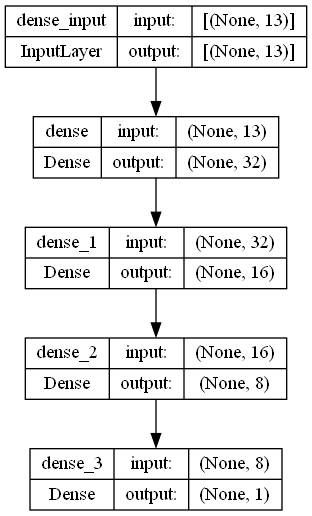

In [43]:
keras.utils.plot_model(model_boston, show_shapes = True)

#### 학습(Train)

In [44]:
hist = model_boston.fit(train_dataset, 
                        epochs = N_EPOCH,
                        validation_data = test_dataset)

Epoch 1/200
1/1 [==============================] - 4s 4s/step - loss: 592.7670 - val_loss: 610.8075
Epoch 2/200
1/1 [==============================] - 0s 79ms/step - loss: 582.2697 - val_loss: 603.5632
Epoch 3/200
1/1 [==============================] - 0s 48ms/step - loss: 577.4246 - val_loss: 595.2667
Epoch 4/200
1/1 [==============================] - 0s 59ms/step - loss: 567.7039 - val_loss: 585.6584
Epoch 5/200
1/1 [==============================] - 0s 42ms/step - loss: 556.3108 - val_loss: 574.2402
Epoch 6/200
1/1 [==============================] - 0s 39ms/step - loss: 545.1740 - val_loss: 560.7397
Epoch 7/200
1/1 [==============================] - 0s 38ms/step - loss: 533.4029 - val_loss: 544.5043
Epoch 8/200
1/1 [==============================] - 0s 41ms/step - loss: 517.2045 - val_loss: 525.4392
Epoch 9/200
1/1 [==============================] - 0s 49ms/step - loss: 499.3381 - val_loss: 502.7787
Epoch 10/200
1/1 [==============================] - 0s 38ms/step - loss: 470.5678 - 

#### 결과 시각화
- 학습 시 epoch별 검증 결과를 시각화

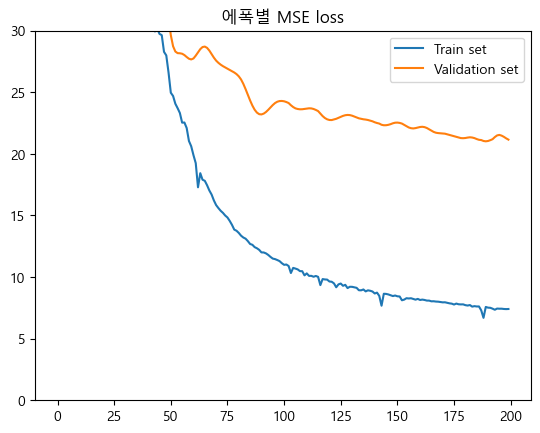

In [45]:
plt.plot(hist.epoch, hist.history['loss'], label='Train set')
plt.plot(hist.epoch, hist.history['val_loss'], label='Validation set')

plt.title('에폭별 MSE loss')
plt.ylim(0, 30)
plt.legend()
plt.show()

#### 최종 테스트

In [46]:
loss = model_boston.evaluate(test_dataset)

3/3 [==============================] - 0s 5ms/step - loss: 21.1566


#### 모델 네트워크 저장

In [47]:
import os
path = 'saved_model'
os.makedirs(path, exist_ok = True)

In [48]:
saved_dir = os.path.join(path, 'boston_model')
print(saved_dir)
model_boston.save(saved_dir)

saved_model\boston_model


INFO:tensorflow:Assets written to: saved_model\boston_model\assets


INFO:tensorflow:Assets written to: saved_model\boston_model\assets


#### 새로운 데이터 추론

In [49]:
# 저장된 모델 불러와 추론
saved_model = keras.models.load_model(saved_dir)
saved_model.evaluate(test_dataset)

3/3 [==============================] - 1s 8ms/step - loss: 21.1566


21.1566219329834

In [50]:
X_new = X_test[:5]
pred = saved_model.predict(X_new)
print(pred)

1/1 [==============================] - 0s 264ms/step
[[ 8.155615]
 [19.217352]
 [21.872103]
 [35.54864 ]
 [25.270071]]


In [51]:
y_test[:5]

array([ 7.2, 18.8, 19. , 27. , 22.2])

## 분류(Classification)
### Fashion MNIST Dataset - 다중분류(Multi-Class Classification) 문제
- 10개의 범주(category)와 70,000개의 흑백 이미지로 구성된 패션 MNIST 데이터셋
- 이미지는 해상도(28 X 28 픽셀)가 낮고 다음처럼 개별 의류 품목을 나타냄
- 이미지는 28 X 28 크기이며 Gray scale이다
![image](https://production-media.paperswithcode.com/datasets/Fashion-MNIST-0000000040-4a13281a_m8bp4wm.jpg)

- 레이블(label)은 0에서 9까지의 정수 배열
- 아래 표는 이미지에 있는 의류 클래스(class)들이다
<table>
  <tr>
    <th>레이블</th>
    <th>클래스</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trousers</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

- 각 이미지는 하나의 레이블에 매핑
- 데이터셋에 클래스 이름이 들어있지 않아 나중에 이미지를 출력할 때 사용하기 위해 별도의 변수를 만들어 저장

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers

import numpy as np
import matplotlib.pyplot as plt

import os
import random

# seed값 설정
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

In [2]:
class_names = np.array(['T-shirt/top', 'Trousers', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])

#### Data 로딩

In [3]:
(train_image, y_train), (test_image, y_test) = keras.datasets.fashion_mnist.load_data()
train_image.shape, y_train.shape, test_image.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
np.unique(y_train, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000],
       dtype=int64))

#### Validation dataset set 분리
- Train set을 Train/Validation set으로 분리

In [5]:
from sklearn.model_selection import train_test_split

train_image, val_image, y_train, y_val = train_test_split(train_image, y_train, test_size = 0.2, stratify = y_train, random_state = 0)
train_image.shape, val_image.shape

((48000, 28, 28), (12000, 28, 28))

#### 이미지 확인

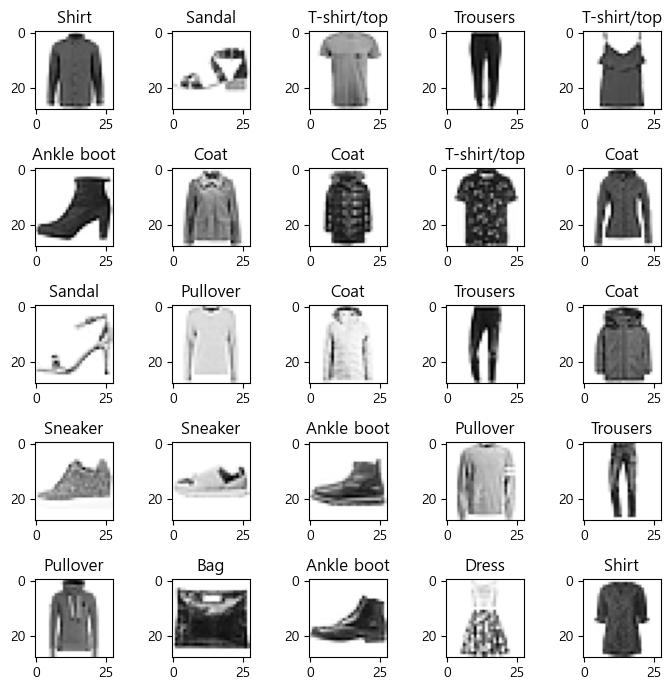

In [6]:
cnt = 25
plt.figure(figsize=(7, 7))
for i in range(cnt):
    plt.subplot(5, int(cnt/5), i+1)
    plt.imshow(train_image[i], cmap = 'Greys')
    label = class_names[y_train[i]]
    plt.title(label)
    
plt.tight_layout()
plt.show()

#### 하이퍼파라미터, 변수 설정

In [7]:
LEARNING_RATE = 0.001
N_EPOCH = 100
N_BATCH = 1000

In [8]:
y_train

array([6, 5, 0, ..., 7, 4, 9], dtype=uint8)

#### X, y 전처리
- y값 처리
    1. 다중분류에서 label encoding 형식의 label을 one hot encoding처리
        - loss: categorical_crossentropy
    2. label encoding 형식의 label을 그대로 모델에 전달
        - loss: sparse_categorical_crossentropy
        - one hot encoding 처리를 loss가 대신 한다
- X값(이미지)처리
    - dtype을 uint8에서 float32로 변환
    - 0 ~ 1 정규화, X/255.0으로 나눈다

In [9]:
X_train = train_image.astype('float32')/255.0
X_val = val_image.astype('float32')/255.0
X_test = test_image.astype('float32')/255.0

In [10]:
print(train_image.min(), train_image.max())
print(X_train.min(), X_train.max())

0 255
0.0 1.0


#### Dataset 생성

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(X_train.shape[0]).batch(N_BATCH, drop_remainder=True)

# validation / test dataset을 동일한 구조로 생성
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(N_BATCH)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(N_BATCH)

In [13]:
# 에폭당 step 수 계산
len(train_dataset), len(val_dataset), len(test_dataset)

(48, 12, 10)

#### 모델 생성 및 컴파일

In [20]:
def get_model_fashion(lr = 0.01):
    model = keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28)))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(10, activation='softmax', name='output'))
    
    model.compile(optimizer = optimizers.Adam(learning_rate = lr),
                  loss = 'sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [21]:
model_fashion = get_model_fashion(LEARNING_RATE)
model_fashion.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               200960    
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 32)                2080      
                                                                 
 output (Dense)              (None, 10)                330       
                                                                 
Total params: 244,522
Trainable params: 244,522
Non-tr

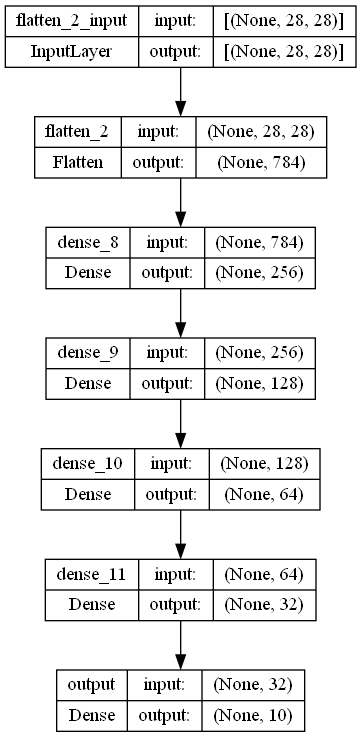

In [22]:
keras.utils.plot_model(model_fashion, show_shapes=True)

#### Train(학습)

In [23]:
hist = model_fashion.fit(train_dataset, epochs=N_EPOCH, validation_data = val_dataset)

Epoch 1/100
48/48 [==============================] - 6s 51ms/step - loss: 0.9329 - accuracy: 0.6883 - val_loss: 0.5656 - val_accuracy: 0.7929
Epoch 2/100
48/48 [==============================] - 2s 35ms/step - loss: 0.4856 - accuracy: 0.8321 - val_loss: 0.4471 - val_accuracy: 0.8413
Epoch 3/100
48/48 [==============================] - 2s 34ms/step - loss: 0.4245 - accuracy: 0.8528 - val_loss: 0.3998 - val_accuracy: 0.8533
Epoch 4/100
48/48 [==============================] - 2s 36ms/step - loss: 0.3851 - accuracy: 0.8639 - val_loss: 0.3923 - val_accuracy: 0.8553
Epoch 5/100
48/48 [==============================] - 2s 39ms/step - loss: 0.3686 - accuracy: 0.8696 - val_loss: 0.3690 - val_accuracy: 0.8664
Epoch 6/100
48/48 [==============================] - 2s 40ms/step - loss: 0.3507 - accuracy: 0.8753 - val_loss: 0.3748 - val_accuracy: 0.8626
Epoch 7/100
48/48 [==============================] - 2s 39ms/step - loss: 0.3317 - accuracy: 0.8827 - val_loss: 0.3414 - val_accuracy: 0.8779
Epoch 

#### 결과 시각화
- 학습 시 epoch별 검증 결과를 시각화

In [24]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

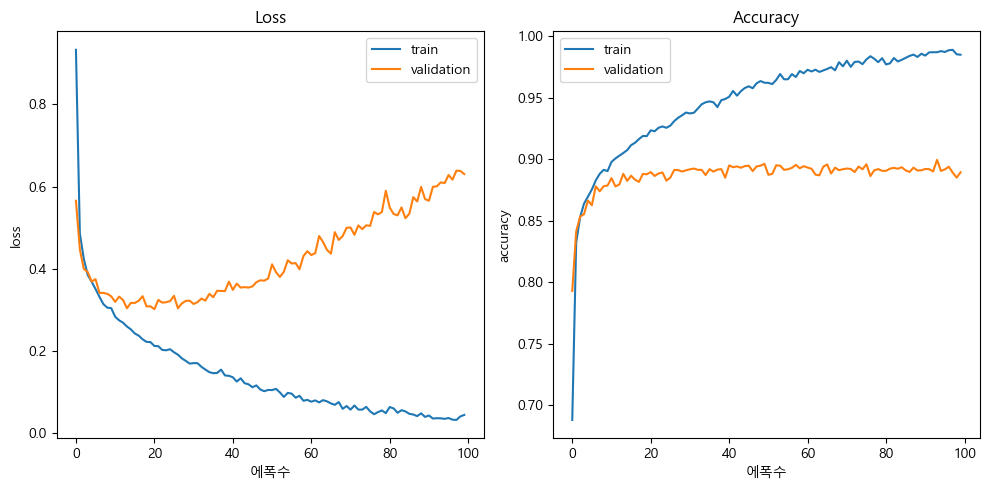

In [25]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.epoch, hist.history['loss'], label='train')
plt.plot(hist.epoch, hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('에폭수')
plt.ylabel('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist.epoch, hist.history['accuracy'], label='train')
plt.plot(hist.epoch, hist.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('에폭수')
plt.ylabel('accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
model_fashion2 = get_model_fashion(LEARNING_RATE)

hist = model_fashion2.fit(train_dataset, epochs = 20, validation_data = val_dataset)

Epoch 1/20
48/48 [==============================] - 5s 41ms/step - loss: 1.0156 - accuracy: 0.6528 - val_loss: 0.6022 - val_accuracy: 0.7776
Epoch 2/20
48/48 [==============================] - 2s 46ms/step - loss: 0.5144 - accuracy: 0.8179 - val_loss: 0.4793 - val_accuracy: 0.8265
Epoch 3/20
48/48 [==============================] - 2s 37ms/step - loss: 0.4540 - accuracy: 0.8405 - val_loss: 0.4277 - val_accuracy: 0.8489
Epoch 4/20
48/48 [==============================] - 2s 38ms/step - loss: 0.4037 - accuracy: 0.8597 - val_loss: 0.3996 - val_accuracy: 0.8569
Epoch 5/20
48/48 [==============================] - 3s 52ms/step - loss: 0.3851 - accuracy: 0.8650 - val_loss: 0.4040 - val_accuracy: 0.8548
Epoch 6/20
48/48 [==============================] - 2s 41ms/step - loss: 0.3573 - accuracy: 0.8740 - val_loss: 0.3805 - val_accuracy: 0.8587
Epoch 7/20
48/48 [==============================] - 2s 36ms/step - loss: 0.3375 - accuracy: 0.8793 - val_loss: 0.3531 - val_accuracy: 0.8687
Epoch 8/20
48

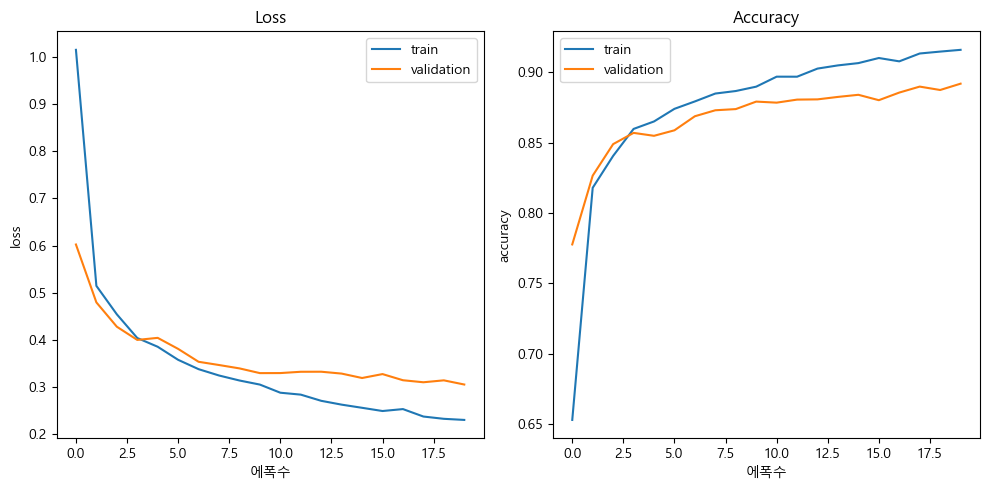

In [27]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.epoch, hist.history['loss'], label='train')
plt.plot(hist.epoch, hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('에폭수')
plt.ylabel('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist.epoch, hist.history['accuracy'], label = 'train')
plt.plot(hist.epoch, hist.history['val_accuracy'], label = 'validation')
plt.title('Accuracy')
plt.xlabel('에폭수')
plt.ylabel('accuracy')
plt.legend()

plt.tight_layout()
plt.show()

#### 최종평가

In [28]:
loss, acc = model_fashion2.evaluate(test_dataset)

10/10 [==============================] - 1s 23ms/step - loss: 0.3348 - accuracy: 0.8821


In [29]:
print(loss, acc, sep=', ')

0.33479276299476624, 0.882099986076355


#### 모델 저장

In [30]:
save_dir_fashion = 'saved_model/fashion_mnist_model'

In [31]:
model_fashion2.save(save_dir_fashion)

INFO:tensorflow:Assets written to: saved_model/fashion_mnist_model\assets


INFO:tensorflow:Assets written to: saved_model/fashion_mnist_model\assets


#### 새로운 데이터 추론

In [32]:
saved_model_fashion = models.load_model(save_dir_fashion)
saved_model_fashion.evaluate(test_dataset)

10/10 [==============================] - 1s 13ms/step - loss: 0.3348 - accuracy: 0.8821


[0.33479276299476624, 0.882099986076355]

In [33]:
new_X = X_test[1000:1010]
new_X.shape

(10, 28, 28)

In [34]:
pred = saved_model_fashion.predict(new_X)
pred.shape

1/1 [==============================] - 0s 439ms/step


(10, 10)

In [35]:
# 모델 추론결과에 대한 후처리 작업
label = np.argmax(pred, axis=-1)
label_name = class_names[label]
proba = np.max(pred, axis=-1)
label, label_name, proba*100

(array([6, 3, 5, 5, 2, 4, 5, 9, 6, 3], dtype=int64),
 array(['Shirt', 'Dress', 'Sandal', 'Sandal', 'Pullover', 'Coat', 'Sandal',
        'Ankle boot', 'Shirt', 'Dress'], dtype='<U11'),
 array([62.501526, 99.91073 , 99.99979 , 99.99969 , 52.02094 , 40.028027,
        99.999985, 99.30052 , 68.929504, 96.98589 ], dtype=float32))

In [36]:
for idx, (n, p) in enumerate(zip(label_name, proba), start = 1):
    print(f"{idx}. {n} - {int(p*100)}%")

1. Shirt - 62%
2. Dress - 99%
3. Sandal - 99%
4. Sandal - 99%
5. Pullover - 52%
6. Coat - 40%
7. Sandal - 99%
8. Ankle boot - 99%
9. Shirt - 68%
10. Dress - 96%


In [37]:
class_names[y_test[1000:1010]]

array(['T-shirt/top', 'Dress', 'Sandal', 'Sandal', 'Shirt', 'T-shirt/top',
       'Sandal', 'Ankle boot', 'Shirt', 'Dress'], dtype='<U11')

## 이진분류(Binary Classification) 문제
### 위스콘신 유방암 데이터셋
- 위스콘신 대학교에서 제공한 종양의 악성/양성여부 분류를 위한 데이터셋
- 이진 분류 문제 처리 모델의 두가지 방법
    1. **positive(1)일 확률을 출력하도록 구현**
        - output layer: units = 1, activation = 'sigmoid'
        - loss: binary_crossentropy
    2. **negative(0)일 확률과 positive(1)일 확률을 출력하도록 구현**
        - 다중 분류 처리 방식으로 해결
        - ouput layer: units = 2, activation = 'softmax', y(정답)는 one hot encoding 처리
        - loss: categorical_crossentropy
- Feature
    - 종양에 대한 다양한 측정값들
- Target의 class
    - 0: malignant(악성종양)
    - 1: benign(양성종양)

In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import random
import numpy as np
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

#### 데이터 로딩, train/validation/test set 나누기

In [39]:
X, y = load_breast_cancer(return_X_y=True)
X.shape, y.shape

((569, 30), (569,))

In [40]:
np.unique(y)

array([0, 1])

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, stratify = y_train, random_state = 0)

X_train.shape, X_val.shape, X_test.shape

((364, 30), (91, 30), (114, 30))

#### 하이퍼파라미터, 변수 정의

In [43]:
LEARNING_RATE = 0.001
N_EPOCH = 200
N_BATCH = 100
N_BATCH_VAL_TEST = 50

#### 데이터 전처리
- y(label) 처리
    - 이진 분류
        - 양성의 확률을 출력하도록 모델을 구성하는 경우 그대로 사용
        - 양성일 확률, 음성일 확률을 출력하도록 모델을 구성하는 경우(다중분류 방식으로 처리) one hot encoding 처리
- X(feature) 처리
    - 문자열(범주형): one hot encoding
    - 연속형(수치형): feature scaling

In [44]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#### Dataset 생성

In [45]:
train_size = X_train_scaled.shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train)).shuffle(train_size).batch(N_BATCH, drop_remainder = True)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_scaled, y_val)).batch(N_BATCH_VAL_TEST)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test)).batch(N_BATCH_VAL_TEST)

#### Model 생성, 컴파일

In [46]:
from tensorflow.keras.metrics import Recall, Precision

def get_model_cancer(lr = 0.01):
    model = keras.Sequential()
    model.add(layers.Dense(32, activation = 'relu', input_shape = (30, )))
    model.add(layers.Dense(16, activation = 'relu'))
    model.add(layers.Dense(1, activation = 'sigmoid', name = 'output_layer'))
    
    model.compile(optimizer = optimizers.Adam(learning_rate = lr),
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy', Recall()])
    return model

In [47]:
model_cancer = get_model_cancer(LEARNING_RATE)
model_cancer.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 32)                992       
                                                                 
 dense_17 (Dense)            (None, 16)                528       
                                                                 
 output_layer (Dense)        (None, 1)                 17        
                                                                 
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


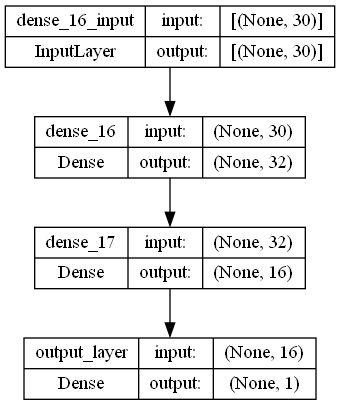

In [48]:
keras.utils.plot_model(model_cancer, show_shapes = True)

#### Train(학습)

In [49]:
hist = model_cancer.fit(train_dataset, epochs = N_EPOCH, validation_data = val_dataset)

Epoch 1/200
3/3 [==============================] - 5s 355ms/step - loss: 0.5983 - accuracy: 0.7333 - recall: 0.8783 - val_loss: 0.5505 - val_accuracy: 0.7692 - val_recall: 0.8596
Epoch 2/200
3/3 [==============================] - 0s 36ms/step - loss: 0.5256 - accuracy: 0.8033 - recall: 0.9000 - val_loss: 0.5011 - val_accuracy: 0.8242 - val_recall: 0.8947
Epoch 3/200
3/3 [==============================] - 0s 32ms/step - loss: 0.4835 - accuracy: 0.8200 - recall: 0.9180 - val_loss: 0.4584 - val_accuracy: 0.8681 - val_recall: 0.9298
Epoch 4/200
3/3 [==============================] - 0s 37ms/step - loss: 0.4224 - accuracy: 0.8733 - recall: 0.9430 - val_loss: 0.4215 - val_accuracy: 0.8681 - val_recall: 0.9298
Epoch 5/200
3/3 [==============================] - 0s 58ms/step - loss: 0.3915 - accuracy: 0.8833 - recall: 0.9471 - val_loss: 0.3881 - val_accuracy: 0.8571 - val_recall: 0.9123
Epoch 6/200
3/3 [==============================] - 0s 46ms/step - loss: 0.3635 - accuracy: 0.8900 - recall: 0

#### 결과 시각화

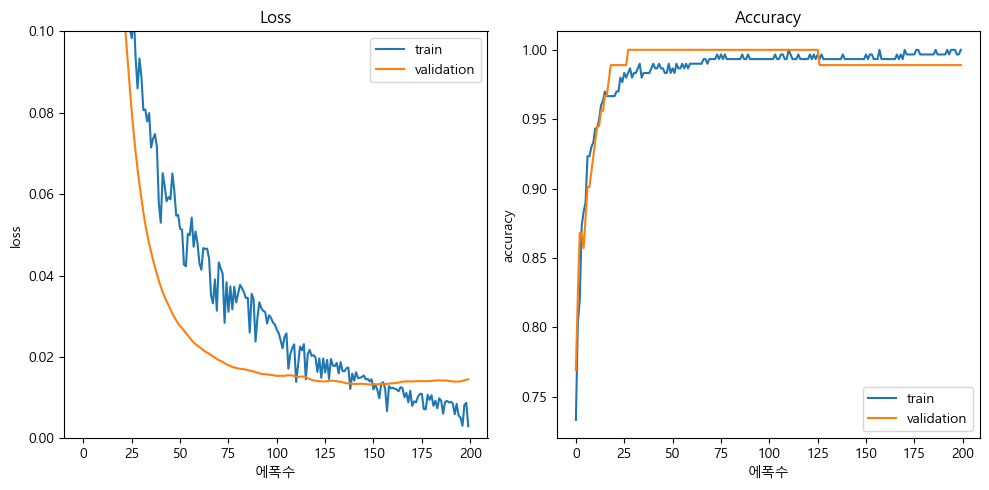

In [50]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.epoch, hist.history['loss'], label='train')
plt.plot(hist.epoch, hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.ylim(0, 0.1)
plt.xlabel('에폭수')
plt.ylabel('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist.epoch, hist.history['accuracy'], label='train')
plt.plot(hist.epoch, hist.history['val_accuracy'], label = 'validation')
plt.title('Accuracy')
plt.xlabel('에폭수')
plt.ylabel('accuracy')
plt.legend()

plt.tight_layout()
plt.show()

#### 최종평가

In [51]:
loss, acc, recall = model_cancer.evaluate(test_dataset)
print(loss, acc, recall)

3/3 [==============================] - 0s 7ms/step - loss: 0.1495 - accuracy: 0.9649 - recall: 0.9861
0.14952515065670013 0.9649122953414917 0.9861111044883728


#### 모델저장

In [52]:
save_dir_path = 'saved_model/cancer_model'

In [53]:
model_cancer.save(save_dir_path)

INFO:tensorflow:Assets written to: saved_model/cancer_model\assets


INFO:tensorflow:Assets written to: saved_model/cancer_model\assets


#### 새로운 데이터 추론

In [54]:
saved_model = get_model_cancer(LEARNING_RATE)
saved_model.evaluate(test_dataset)

3/3 [==============================] - 1s 8ms/step - loss: 0.6476 - accuracy: 0.6316 - recall_1: 1.0000


[0.647607684135437, 0.6315789222717285, 1.0]

In [55]:
saved_model = models.load_model(save_dir_path)
saved_model.evaluate(test_dataset)

3/3 [==============================] - 1s 10ms/step - loss: 0.1495 - accuracy: 0.9649 - recall: 0.9861


[0.14952515065670013, 0.9649122953414917, 0.9861111044883728]

In [56]:
new_X = X_test_scaled[:10]
pred = saved_model.predict(new_X)
pred.shape

1/1 [==============================] - 0s 295ms/step


(10, 1)

In [57]:
print(pred)
print(np.round(pred, 3))

[[2.7873192e-04]
 [2.7264950e-16]
 [2.8394345e-07]
 [9.9997908e-01]
 [2.0943771e-05]
 [9.9809438e-01]
 [6.7332861e-05]
 [9.9990022e-01]
 [9.9999464e-01]
 [1.4204730e-12]]
[[0.   ]
 [0.   ]
 [0.   ]
 [1.   ]
 [0.   ]
 [0.998]
 [0.   ]
 [1.   ]
 [1.   ]
 [0.   ]]


#### 모델 출력 결과 후처리

In [58]:
np.where(pred >= 0.5, '양성종양 : 1', '악성종양 : 0')

array([['악성종양 : 0'],
       ['악성종양 : 0'],
       ['악성종양 : 0'],
       ['양성종양 : 1'],
       ['악성종양 : 0'],
       ['양성종양 : 1'],
       ['악성종양 : 0'],
       ['양성종양 : 1'],
       ['양성종양 : 1'],
       ['악성종양 : 0']], dtype='<U8')

In [59]:
y_test[:10]

array([0, 0, 0, 1, 0, 1, 0, 1, 1, 0])